# 00 - Preprocess the Governance Data Set
This notebook explores and preprocesses the governence documents data set. We experiment with extraction from various forms of input document, word clouds to get a sense of word frequency and of course machine learning algorithms.

---
## Installation and Dependencies
Here we install dependencies.

For text extraction from the Word documents we use [Antiword](https://pypi.org/project/antiword/), a text extraction front-end to Libreoffice. Your Notebook server should have [Libreoffice](https://www.libreoffice.org/) installed.

For PDF we use two-stage extraction: if the text extraction does not yield a significant document, we run Tesseract OCR on the documents to extract text from the images-as-pages form of PDFs.

In [1]:
!pip install pandas pymupdf filetype textract antiword nltk spacy wordcloud beautifulsoup4 unidecode pdf2image pytesseract fastparquet geopandas
!python -m spacy download nl_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')


In [2]:
import re
import sys
import hashlib
from pathlib import Path
WRITE='w'
READ_BINARY='rb'
import multiprocessing
from multiprocessing import Pool
from collections import Counter
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

import fitz
from fitz import VersionFitz as fitz__version__
print(f"pymupdf=={fitz__version__}")

import filetype
print(f"filetype=={filetype.__version__}")

import textract
from textract import VERSION as textract__version__
print(f"textract=={textract__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import spacy
print(f"spacy=={spacy.__version__}")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
print(f"nltk=={nltk.__version__}")

from bs4 import BeautifulSoup
from bs4 import __version__ as bs4__version__
print(f"beautifulsoup4=={bs4__version__}")

import chardet
print(f"chardet=={chardet.__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INT32 = 'int32'
UNSIGNED = 'unsigned'
FLOAT = 'float'
GZIP='gzip'

from unidecode import unidecode

from pdf2image import convert_from_path
from pdf2image.exceptions import PDFPageCountError

import pytesseract
print(f"pytesseract=={pytesseract.__version__}")

import geopandas as gpd
print(f"geopandas=={gpd.__version__}")


python==3.11.4
pymupdf==1.22.0
filetype==1.2.0
textract==1.6.5
wordcloud==1.9.2
matplotlib==3.7.1
spacy==3.5.3
nltk==3.8.1
beautifulsoup4==4.8.2
chardet==3.0.4
pandas==2.0.2
pytesseract==0.3.10
geopandas==0.13.2


### Enexis Colour Scheme
While not strictly needed for the analysis, we strive to use the Enexis style and colour scheme where we can. Here we define a colour map for our mapping work.

Defining a colour map is not a trivial operation and there are no installable libraries, so we copied the complete [Matplotlib CMap Generator](https://github.com/mvfki/assignments/blob/master/matplotlib_cmap_generator.py) by [Yichen Wang](https://github.com/mvfki). Not ideal, but workable.

In [3]:
"""
@author: Yichen Wang
@date: 06/30/2020
@see https://github.com/mvfki/assignments/blob/master/matplotlib_cmap_generator.py
"""
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import numpy as np

def generateCmap(breakPointColors, breakPoints=None, sensitivity=256, 
               name="userCmap"):
    '''
    Aimed at generate user customized ListedColormap instance, to be used when 
    plotting with matplotlib.
    Arguments:
    ----------
    breakPointColors: 
        An array of color difinitions. Can be "rgba" vector or a string (like 
        "red") that `matplotlib.colors.to_rgba()` accepts.
    breakPoints: 
        Optional. An array of numbers that defines the border of color 
        gradients. The values does not necessarily match the border of the 
        data to plot, but will be reflected as ratio on the plot. Must be of 
        the same length as `breakPointColors`.
    sensitivity: 
        An integer for how many intrinsic intervals in the colormap. Default 
        `256`. Should use larger value if there are breakpoints close to each 
        other.
    Return:
    ----------
        a matplotlib.colors.ListedColormap object, that can be used for "cmap"
    argument in matplotlib plotting function.
    Example:
    ----------
    >>> import matplotlib.pyplot as plt
    >>> cmap = generateCmap(['blue', 'white', 'red'])
    >>> plt.scatter(range(100), range(100), c=range(100), cmap=cmap)
    '''
    # Input Check
    assert len(breakPointColors) >= 2
    if breakPoints != None:
        assert len(breakPoints) == len(breakPointColors)
        assert len(set(breakPoints)) == len(breakPoints), \
               "Should not give duplicated value in 'breakPoints'"
    else:
        breakPoints = list(range(len(breakPointColors)))
    
    breakPointColors = np.array(breakPointColors)
    assert len(breakPointColors.shape) == 1 or \
           len(breakPointColors.shape) == 2
    if len(breakPointColors.shape) == 1:
        assert str(breakPointColors.dtype).startswith('<U'), \
               "Color specification dtype not understandable"
    elif len(breakPointColors.shape) == 2:
        assert breakPointColors.shape[1] in [3, 4] and \
               breakPointColors.dtype in ['int32', 'float64'], \
               "'rgb(a)' color specification not understandable."

    ## Randomly fetch an ListedColormap object, and modify the colors inside
    cmap = cm.get_cmap("viridis", sensitivity)
    cmap.name = name
    
    # Format the input
    minBP, maxBP = min(breakPoints), max(breakPoints)
    scaledBP = [round((i-minBP)/(maxBP-minBP)*(sensitivity-1)) \
                for i in breakPoints]
    assert len(set(scaledBP)) == len(breakPoints), \
           "Sensitivity too low"
    sortedBP = sorted(scaledBP)
    sortedBPC = []
    for i in sortedBP:
        idx = scaledBP.index(i)
        sortedBPC.append(breakPointColors[idx])
    BPC_rgba = np.array([colors.to_rgba(i) for i in sortedBPC])
    # Now replace colors in the Colormap object
    for i in range(1, len(sortedBP)):
        ## Indices when slicing colormap.colors
        start = sortedBP[i-1]
        end = sortedBP[i] + 1
        n = end - start
        ## Color range
        startC = BPC_rgba[i-1]
        endC = BPC_rgba[i]
        for i in range(3):
            cmap.colors[start:end, i] = np.linspace(startC[i], endC[i], n)
        
    return cmap


In [4]:
ENEXIS_PINK='#cc2b72'
ENEXIS_GREEN='#c3da45'
ENEXIS_DARKGREEN='#94b950'
ENEXIS_LIGHTGREY='#f0f0f0'

ENEXIS_CMAP = generateCmap([ENEXIS_GREEN, ENEXIS_PINK])


/tmp/ipykernel_39869/3759607295.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis", sensitivity)


---
## Structure of the Data
As this is a project with unstructured data, we should preserve what little structure there is. The raw data comes as hand written documents from many authors, though the file names are meaningful. This section documents the data structure that we use on disk in this project and defines Python constants and a few [file name globs](https://realpython.com/get-all-files-in-directory-python/#using-a-python-glob-pattern-for-conditional-listing) to make document handling easier.

### Directory Structure
The raw data set is *not* in GIT, simply because of the file size. You can ask the project team for the original data set. The raw data files are stored in `executing-enexis/data/Governance/GM*.*` (known as `GLOB_RAW_DOCUMENTS` in Python code). Extracted text and document artifacts can be found under `executing-enexis/cache/Governance/` (`DATA_DIR` in Python).

### File Name Structure
The file names to the documents are fixed-length records with the following meaning: `"GM"<gemeente code (4-positions)><document type (2 positions)><id number (2 positions>"."<extension>`.

The gemeente code can be mapped with the codes in `../data/cbs-wijk-en-buurtkaart-2016/`.

The two-character document type can be found in the table below. Each document type has a glob for quick access to all documents of that type. These globs can be found in the same table, although you may find the mapping intuitive.

| Document Type ID | Document Type             | Pathlib Glob   |
|------------------|---------------------------|----------------
| CA               | Coalitieakkoord           | `GLOB_CA`      |
| DV               | Duurzaamheidsprogramma    | `GLOB_DV`      |
| EX               | Externe documenten        | `GLOB_EX`      |
| IK               | Inkoopbeleid              | `GLOB_IK`      |
| JS               | Jaarstukken               | `GLOB_JS`      |
| OB               | Overige beleidsdocumenten | `GLOB_OB`      |
| PB               | Programmabegroting        | `GLOB_PB`      |
| TV               | Toekomstvise              | `GLOB_TV`      |
| WS               | Website gemeente          | `GLOB_WS`      |

### File and Data Issues
There are a number of issues with the data set, as is to be expected by a set produced by humans. The data set was constructed for a different purpose, where future text processing was not a requirement.

* The file extension is not completely reliable. Especially documents with extension `.zip` seem not to be of mime type `application/zip`, but rather of type `text/html`. More on that in the text extraction, below.
* Some of the Word documents only contain a URL to what seems to be a municipality website. The system used to collect the data and it seems that some people just created a document with the URL rather than uploading the actual document.
* Some of the PDF documents have been produced with systems that write out the text as images. This makes for pretty formatting, but means we need OCR to extract the actual text from the document.
* Some documents have been mislabelled.

There are a few more, insignificant oddities for which the code below has provisions.

In [5]:
# take any path and map it from the data directory to the cache directory.
def to_cache(path):
    return Path(str(path).replace('/data/', '/cache/'))

DATA_DIR = '../data/Governance'
CACHE_DIR = '../cache/Governance'
Path(CACHE_DIR).mkdir(parents=True, exist_ok=True)

# The raw documents, warts and all; PDFs, ZIP files and Word documents.
GLOB_RAW_DOCUMENTS = DATA_DIR + '/GM????????.*'

# The files containing the extracted text from the raw documents.
GLOB_ALL_DOCUMENTS = CACHE_DIR + '/GM????????.txt'

GLOB_CA = CACHE_DIR + '/GM????CA??.txt'
GLOB_DV = CACHE_DIR + '/GM????DV??.txt'
GLOB_EX = CACHE_DIR + '/GM????EX??.txt'
GLOB_IK = CACHE_DIR + '/GM????IK??.txt'
GLOB_JS = CACHE_DIR + '/GM????JS??.txt'
GLOB_OB = CACHE_DIR + '/GM????OB??.txt'
GLOB_PB = CACHE_DIR + '/GM????PB??.txt'
GLOB_TV = CACHE_DIR + '/GM????TV??.txt'
GLOB_WS = CACHE_DIR + '/GM????WS??.txt'

# The Parquet file for the DV documents data set, gzipped.
DV_PARQUET_GZ = CACHE_DIR + '/DV_documents.parquet.gz'

# The CSV file with metadata for the DV documents data set, such as titles and
# other useful information. We'll merge that into the DV parquet file for
# reference.
DV_DOCUMENTS_CSV = DATA_DIR + "/Duurzaamheidsvisies.csv"

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"raw documents: {GLOB_RAW_DOCUMENTS}")
print(f"extracted documents = {GLOB_ALL_DOCUMENTS}")


raw documents: ../data/Governance/GM????????.*
extracted documents = ../cache/Governance/GM????????.txt


---
## Text Extraction
This section extracts the text from the raw documents. It deals with the file formats and file encodings. Text extraction from Word files is done with Antiword and Libreoffice. For the PDFs we use [PyMuPDF](https://pypi.org/project/PyMuPDF/) instead. Antiword's development seems to have stagnated, so we only use it where we have to. HTML is cleaned up using [Beautiful Soup](https://pypi.org/project/beautifulsoup4/).

As usual there are a few document oddities to contend with: a mix of file encodings, some documents are empty and some have the wrong [MIME type](https://en.wikipedia.org/wiki/Media_type#Mime.types). For example, documents with extension `.zip` seem not to be of MIME type `application/zip`, but rather of type `text/html`. Some of these `.zip` files are empty as well. There is one text document that contains CSS, so we exclude that specific file.

For tokenization we chose quite a limited set of acceptable characters: only alphabetic characters and a few [accented characters](https://nl.wikipedia.org/wiki/Accenttekens_in_de_Nederlandse_spelling) that are common in the Dutch language. Early experiments showed that a lot of numerical "words" would creep into the data. That makes sense as many of these documents talk about finance, but hinders finding meaning. Numbers really only make sense in context and we simply don't have the context. By stripping out the numbers we also stripped the years out of the text, which do have meaning out of context. We chose to leave these out.

The text extraction also performs some light preprocessing on the text, such as [stop word removal](https://en.wikipedia.org/wiki/Stop_word) and [stemming](https://en.wikipedia.org/wiki/Stemming), taking care to use the Dutch form of each of these. These are fairly slow operations, so they combine well with the extract-and-cache step of the process. That said, we should not preprocess too much, lest we subtly change the meaning of the text.

Due to the nature, number and size of the raw documents, text extraction takes quite a bit of time. To speed up iterating over the data set we cache the resultant files in `CACHE_DIR` for quick access. These can then be accessed using the globs defined earlier.





 


In [6]:
# Download additional dependencies. These come as downloadable sets with NLTK.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# The stopwords for the Dutch language.
dutch_stopwords = set(stopwords.words('dutch'))

# The lemmatization utility, also for the Dutch language.
dutch_lemmatizer = spacy.load("nl_core_news_sm")
dutch_lemmatizer.max_length = 1500000 # uses a lot of RAM


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def lemmatized_tokens(text, lemmatizer):
    text = " ".join(text.splitlines())      # remove line endings and make the file one, huge string,
    text = unidecode(text)                  # boil Unicode back to ASCII, removing accents,
    text = text.lower().strip()             # lowercase everything
    text = re.sub(r'[^a-zA-Z]+', ' ', text) # and use only letter sequences as tokens/words/terms
    
    return [token.lemma_ for token in lemmatizer(text)]

def cleaned_and_lemmatized_text(from_file, text, stopwords, lemmatizer):
    text = ' '.join([token for token in lemmatized_tokens(text, lemmatizer) if (token not in stopwords) and (len(token) > 2)])
    if len(text) < 2048:
        print(f"suspiciously small file {from_file} has only {len(text)} characters")
    return text

# we look for text in PDF's both as document text and by running OCR on the
# pages. This way we are robust against documents that have been generated in
# image format too.
def extract_pdf(from_file, to_file, stopwords, lemmatizer):
    text = ""
    for page in fitz.open(from_file):
        text = text + ' ' + page.get_text('text')
    
    # if the extracted text is tiny, we run OCR as well
    if len(text) < 100:
        try:
            print(f"{from_file} has only {len(text)} characters, trying OCR...")
            for page in convert_from_path(from_file.resolve()):
                text = text + ' ' + pytesseract.image_to_string(page)
        except PDFPageCountError as e:
            print(f"OCR failed on {from_file}: {str(e)}")

    with open(to_file, WRITE) as f:
        text = cleaned_and_lemmatized_text(from_file, text, stopwords, lemmatizer)
        f.write(text)
        f.write(' ')

def extract_msword(from_file, to_file, stopwords, lemmatizer):
    with open(to_file, WRITE) as f:
        text = str(textract.process(str(from_file)))
        text = cleaned_and_lemmatized_text(from_file, text, stopwords, lemmatizer)
        f.write(text)

def encoding_of(file):
    rawdata = open(file, READ_BINARY).read()
    if len(rawdata) == 0:
        return 'ascii'
    encoding = chardet.detect(rawdata)['encoding']
    print(f"loading {file} using {encoding} encoding")
    return encoding

def extract_plain(from_file, to_file, stopwords, lemmatizer):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            text = cleaned_and_lemmatized_text(from_file, text, stopwords, lemmatizer)
            f.write(text)

# https://stackoverflow.com/questions/328356/extracting-text-from-html-file-using-python

def extract_html(from_file, to_file, stopwords, lemmatizer):
    text = from_file.read_text(encoding=encoding_of(from_file))
    if len(text) == 0:
        print(f"ignoring {from_file} as it is empty")
    else:
        with open(to_file, WRITE) as f:
            soup = BeautifulSoup(text, features="html.parser")
            # r=ip out script and style elements as these would pollute the text
            for script in soup(["script", "style"]):
                script.extract()
            text = soup.get_text()
            
            text = cleaned_and_lemmatized_text(from_file, text, stopwords, lemmatizer)
            f.write(text)

def extract_file(from_file):
    mime_type = filetype.guess_mime(from_file)
    to_file = to_cache(from_file.with_suffix('.txt'))

    if to_file.exists():
        pass
    elif from_file.stem == 'GM1711OB02':
        print(f"ignoring {from_file} as it is of MIME type text/css")
    elif mime_type == "application/pdf":
        extract_pdf(from_file, to_file, dutch_stopwords, dutch_lemmatizer)
    elif mime_type == "application/vnd.openxmlformats-officedocument.wordprocessingml.document" or \
         mime_type == "application/msword":
        extract_msword(from_file, to_file, dutch_stopwords, dutch_lemmatizer)
    elif not mime_type:
        if from_file.suffix.lower() == '.txt':
            extract_plain(from_file, to_file, dutch_stopwords, dutch_lemmatizer)
        if from_file.suffix.lower() == '.zip':
            # seems wrong, but it is correct for our data...
            extract_html(from_file, to_file, dutch_stopwords, dutch_lemmatizer)
    else:
        raise Exception(f"don't known how to handle {from_file} of MIME type {mime_type}")

# trying sequential first...
def extract_dir(glob):
     for from_file in expand_glob(glob):
            extract_file(from_file)
     #with Pool(multiprocessing.cpu_count() + 1) as p:
     #   p.map(extract_file, [file for file in expand_glob(glob)])


In [8]:
extract_dir(GLOB_RAW_DOCUMENTS)

loading ../data/Governance/GM0007CA01.zip using ascii encoding
suspiciously small file ../data/Governance/GM0007CA01.zip has only 101 characters
suspiciously small file ../data/Governance/GM0014OB04.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0040WS01.docx has only 14 characters
suspiciously small file ../data/Governance/GM0056WS01.docx has only 37 characters
suspiciously small file ../data/Governance/GM0059OB01.pdf has only 470 characters
suspiciously small file ../data/Governance/GM0063JS01.pdf has only 0 characters
suspiciously small file ../data/Governance/GM0081WS01.docx has only 19 characters
suspiciously small file ../data/Governance/GM0090WS01.docx has only 18 characters
suspiciously small file ../data/Governance/GM0090WS02.docx has only 9 characters
suspiciously small file ../data/Governance/GM0114WS01.docx has only 18 characters
suspiciously small file ../data/Governance/GM0147CA02.pdf has only 0 characters
suspiciously small file ../data/Governance

### Deduplication
The data set was assembled by a group of people answering a questionnaire and uploading document supporting their arguments in the process. Sometimes they would upload the same document to answer more than one question on the questionnaire, so we have a few duplicate files. Here we identify duplicates by checksum and remove their cached text documents.


In [9]:
# https://stackoverflow.com/questions/3431825/generating-an-md5-checksum-of-a-file

def md5(file):
    hash_md5 = hashlib.md5()
    with open(file, READ_BINARY) as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def delete_duplicates(glob):
    hashes = set()
    dupes = 0
    for file in expand_glob(glob):
        hash = md5(file)
        if hash in hashes:
            print(f"deleting {file} as dupe")
            file.unlink()
            dupes += 1
        else:
            hashes.add(hash)
    print(f"deleted {dupes} duplicates")

In [10]:
delete_duplicates(GLOB_ALL_DOCUMENTS)

deleting ../cache/Governance/GM0059IK01.txt as dupe
deleting ../cache/Governance/GM0063CA02.txt as dupe
deleting ../cache/Governance/GM0063CA03.txt as dupe
deleting ../cache/Governance/GM0063JS01.txt as dupe
deleting ../cache/Governance/GM0079EX01.txt as dupe
deleting ../cache/Governance/GM0079IK01.txt as dupe
deleting ../cache/Governance/GM0086CA02.txt as dupe
deleting ../cache/Governance/GM0093DV01.txt as dupe
deleting ../cache/Governance/GM0147CA02.txt as dupe
deleting ../cache/Governance/GM0147CA03.txt as dupe
deleting ../cache/Governance/GM0148DV02.txt as dupe
deleting ../cache/Governance/GM0168DV02.txt as dupe
deleting ../cache/Governance/GM0225CA01.txt as dupe
deleting ../cache/Governance/GM0225JS01.txt as dupe
deleting ../cache/Governance/GM0226IK02.txt as dupe
deleting ../cache/Governance/GM0232CA02.txt as dupe
deleting ../cache/Governance/GM0246IK01.txt as dupe
deleting ../cache/Governance/GM0267PB02.txt as dupe
deleting ../cache/Governance/GM0277OB03.txt as dupe
deleting ../

### Small File Removal
Small files generally indicate that a document is incomplete for one reason or another. We drop those from the data set, because we cannot be sure that they are representative of a typical document.

In [11]:
def delete_small_files(glob):
    deleted = 0
    for file in expand_glob(glob):
        text = file.read_text()
        if len(text) < 2048:
            print(f"deleting {file} as insignificant ({len(text)})")
            file.unlink()
            deleted += 1
            
    print(f"deleted {deleted} insignificants")


In [12]:
delete_small_files(GLOB_ALL_DOCUMENTS)

deleting ../cache/Governance/GM0007CA01.txt as insignificant (101)
deleting ../cache/Governance/GM0014OB04.txt as insignificant (1)
deleting ../cache/Governance/GM0040WS01.txt as insignificant (14)
deleting ../cache/Governance/GM0056WS01.txt as insignificant (37)
deleting ../cache/Governance/GM0059OB01.txt as insignificant (471)
deleting ../cache/Governance/GM0081WS01.txt as insignificant (19)
deleting ../cache/Governance/GM0090WS01.txt as insignificant (18)
deleting ../cache/Governance/GM0090WS02.txt as insignificant (9)
deleting ../cache/Governance/GM0114WS01.txt as insignificant (18)
deleting ../cache/Governance/GM0147OB01.txt as insignificant (334)
deleting ../cache/Governance/GM0147WS03.txt as insignificant (73)
deleting ../cache/Governance/GM0173WS01.txt as insignificant (13)
deleting ../cache/Governance/GM0173WS02.txt as insignificant (21)
deleting ../cache/Governance/GM0180OB01.txt as insignificant (931)
deleting ../cache/Governance/GM0183PB01.txt as insignificant (45)
deleting

### Delete Mislabeled DV Documents
During analysis, we identifed three documents that were labeled as *duurzaamheidvisie*, but that were really something else. We delete these files, so that they do not act as outliers in the DV data set.

In [13]:
DOCUMENT_ID = 'DocID'
DOCUMENT_TITLE = 'Titel'
DOCUMENT_JAAR = 'Jaar'

documents = pd.read_csv(DV_DOCUMENTS_CSV, index_col=DOCUMENT_ID)
documents[DOCUMENT_JAAR]  = documents[DOCUMENT_JAAR].fillna("0000.0").astype(STRING).str.slice(0, 4).astype(INT32)
documents[DOCUMENT_TITLE] = documents[DOCUMENT_TITLE].astype(STRING)
# check for documents that have names like `begroting`
documents[documents[DOCUMENT_TITLE].str.contains("begrot", case=False)]


,Titel,Jaar
DocID,,
GM0331DV01,Programmabegroting 2016,2015
GM0852DV01,Programmabegroting 2016,2016
GM0981DV01,Programma begroting 2016,2015


In [14]:
MISLABELLED=['GM0331DV01', 'GM0852DV01', 'GM0981DV01']
for basename in MISLABELLED:
    file = Path(f"{CACHE_DIR}/{basename}.txt")
    file.unlink()
    print(f"deleted {file} as it was mislabeled")


deleted ../cache/Governance/GM0331DV01.txt as it was mislabeled
deleted ../cache/Governance/GM0852DV01.txt as it was mislabeled
deleted ../cache/Governance/GM0981DV01.txt as it was mislabeled


---
## Load Municipalities Map
Next we load the Dutch municipalities as a shape file into Geo Pandas. We rely on CBS' shape file for the Dutch municipalities. Our documents were collected in 2016, so we use the shape file from that same year. The original data can be found as [Wijk- en buurtkaart 2016](https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2016).

We filter out the water areas, as these have no bearing on our analysis and make the maps harder to read. We use the municipality code as data frame index, just like we do for the municipalities metadata set. Adding the water to the plots sounds like a good idea, but the plots are actually harder to read because the country no longer has that well known shape. It is better to ignore water altogether.


In [15]:
MUNICIPALITY_CODE='GM_CODE'

municipalities_map = gpd.read_file('../data/cbs-wijk-en-buurtkaart-2016/gem_2016.shp')
municipalities_map.set_index(MUNICIPALITY_CODE, inplace=True)
municipalities_map = municipalities_map[municipalities_map['WATER'] == 'NEE']
municipalities_map.head()


,GM_NAAM,WATER,OAD,STED,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,P_25_44_JR,...,AV20ATTRAC,AV50ATTRAC,AF_PODIUM,AV5_PODIUM,AV10PODIUM,AV20PODIUM,OPP_TOT,OPP_LAND,OPP_WATER,geometry
GM_CODE,,,,,,,,,,,,,,,,,,,,,
GM0003,Appingedam,NEE,1041,3,12001,5802,6199,15,10,21,...,1.0,11.2,5.6,0.2,1.0,1.0,2458,2378,80,"POLYGON ((251260.528 594393.827, 251261.415 59..."
GM0005,Bedum,NEE,681,4,10433,5230,5203,17,11,21,...,2.5,20.1,9.6,0.0,1.7,6.1,4496,4454,41,"POLYGON ((233048.852 589658.117, 233049.786 58..."
GM0007,Bellingwedde,NEE,151,5,8971,4537,4434,13,10,18,...,0.9,15.8,10.3,0.0,0.3,2.0,11009,10837,172,"POLYGON ((264726.376 570763.684, 264722.634 57..."
GM0009,Ten Boer,NEE,367,5,7352,3660,3692,18,11,21,...,2.3,17.1,11.8,0.0,0.6,7.0,4573,4531,42,"POLYGON ((245194.691 592594.007, 245195.760 59..."
GM0010,Delfzijl,NEE,681,4,25068,12571,12497,14,11,20,...,1.0,8.8,4.5,0.7,0.9,1.2,22750,13313,9436,"MULTIPOLYGON (((269190.000 594253.046, 269190...."


In [16]:
municipalities_map.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 390 entries, GM0003 to GM1987
Columns: 178 entries, GM_NAAM to geometry
dtypes: float64(89), geometry(1), int64(86), object(2)
memory usage: 553.5+ KB


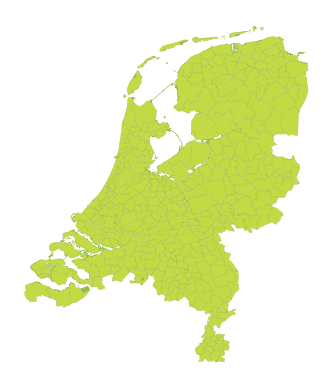

In [17]:
ax = municipalities_map.plot(facecolor=None, color=ENEXIS_GREEN, edgecolor=ENEXIS_DARKGREEN, linewidth=0.2)
ax.set(facecolor='red')
ax.axis('off');


---
## Create DV as Data Frame and Data Parquet File
To speed up and simplify data loading in the subsequent notebooks, we create a Pandas dataframe out of the DV documents and stored that in the cache, compressed. The data frame is indexed by the document identifier for easy reference. We also add the minucipality code as a separate column, for easy joining with the municipality data set and with the CBS maps for the same.

We merge in the documents metadata set. This gives a well annotated dataset to work with.

It was probably quicker if from the start we'd kept all the documents in memory and build the data frame as part of text extraction, but that would mean rewriting a lot of code rather late in the project. This we leave as an excercise for the reader.

In [18]:
DOCUMENT_BODY = 'body'
MUNICIPALITY_ID='GM_CODE'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY]   = df[DOCUMENT_BODY].astype(STRING)
    df[MUNICIPALITY_ID] = df.index.str.slice(0, 6).astype(CATEGORY)

    return df


In [19]:
DV_corpus = load_corpus_as_dataframe(GLOB_DV)
DV_corpus

,body,GM_CODE
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034
...,...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...,GM1945
GM1955DV01,milieuprogramma gemeente Montferland vaststell...,GM1955
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...,GM1955
GM1955DV03,energietransitienota duurzaam energie achterho...,GM1955


In [20]:
DV_corpus_with_municipalities = DV_corpus.join(documents)
DV_corpus_with_municipalities


,body,GM_CODE,Titel,Jaar
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003,DUURZAAMHEIDSBELEID APPINGEDAM 2011-2015,2011
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...,GM0005,Milieubeleidsplan 2009-2012,2009
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...,GM0007,Milieubeleidsprogramma 2007-2015,2007
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...,GM0009,Duurzaamheidsvisie 2016-2018,2016
GM0034DV01,verseonnr dagmail december raad gemeente almer...,GM0034,Plan van aanpak duurzaamheidsagenda,2010
...,...,...,...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...,GM1945,Duurzaamheidsprogramma - Gemeente Berg en Dal,2013
GM1955DV01,milieuprogramma gemeente Montferland vaststell...,GM1955,Milieuprogramma 2014,2014
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...,GM1955,Zonne-energie in het buitengebied,0
GM1955DV03,energietransitienota duurzaam energie achterho...,GM1955,Energietransitienota duurzame Energie Achterhoek,2015


In [21]:
# compressed disk size is about 3.5 MB, so actual memory use is probably higher
# than `info()` suggests.
DV_corpus_with_municipalities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, GM0003DV02 to GM1987DV01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   body     245 non-null    string  
 1   GM_CODE  245 non-null    category
 2   Titel    245 non-null    string  
 3   Jaar     245 non-null    int32   
dtypes: category(1), int32(1), string(2)
memory usage: 25.0+ KB


In [22]:
DV_corpus_with_municipalities.to_parquet(DV_PARQUET_GZ, compression=GZIP) 

---
## Generate Word Clouds
We now go through the text documents again, and generate a word cloud image for each file. There are too many to show word clouds for individual files, so we don't try. We do generate and show the word clouds for a few of the collections of documents.

In [23]:
def make_one_file_cloud(file):
    try:
        cloud = WordCloud(background_color="white", max_words=20).generate(file.read_text())
        cloud.to_file(file.with_suffix('.png'))
    except ValueError as e:
        print(f"cannot generate word cloud for {file}: {e}")

def make_per_file_cloud(glob):
    with Pool(multiprocessing.cpu_count() + 1) as p:
        p.map(make_one_file_cloud, [file for file in expand_glob(glob)])


In [24]:
make_per_file_cloud(GLOB_ALL_DOCUMENTS)

In [25]:
def make_word_cloud(glob):
    corpus = ""
    for file in expand_glob(glob):
        corpus = corpus + " " + file.read_text()

    cloud = WordCloud(background_color="white", max_words=50).generate(corpus)
    plt.axis('off')
    plt.imshow(cloud);


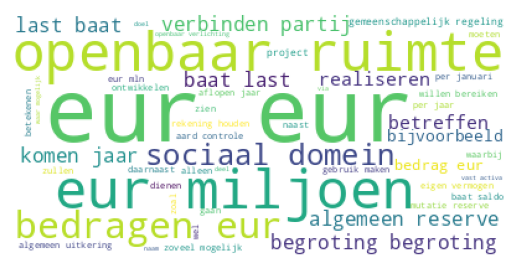

In [26]:
make_word_cloud(GLOB_ALL_DOCUMENTS)


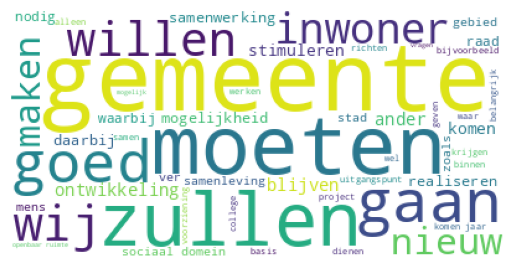

In [27]:
make_word_cloud(GLOB_CA)


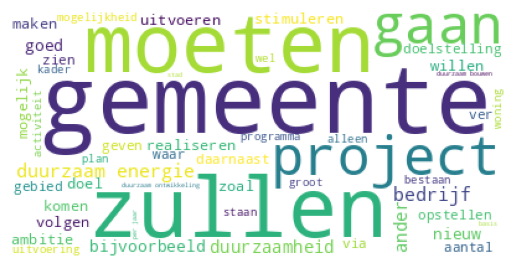

In [28]:
make_word_cloud(GLOB_DV)


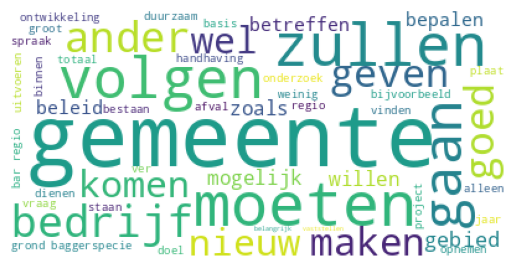

In [29]:
make_word_cloud(GLOB_EX)


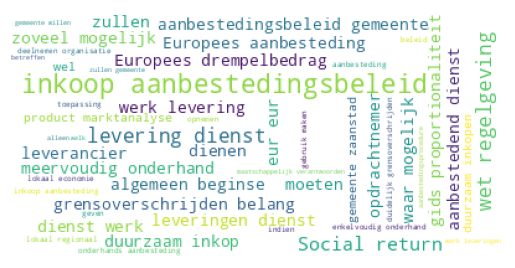

In [30]:
make_word_cloud(GLOB_IK)


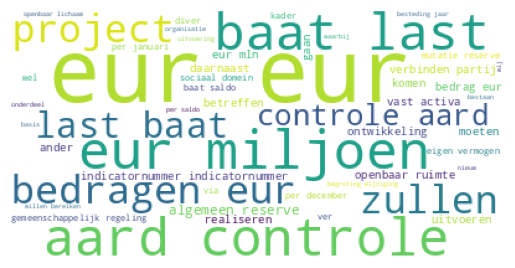

In [31]:
make_word_cloud(GLOB_JS)


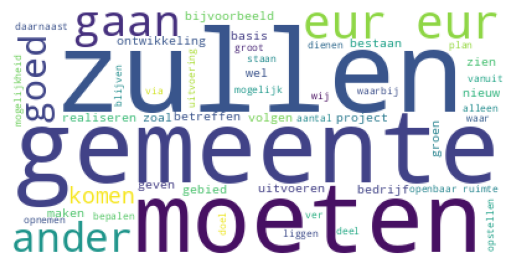

In [32]:
make_word_cloud(GLOB_OB)


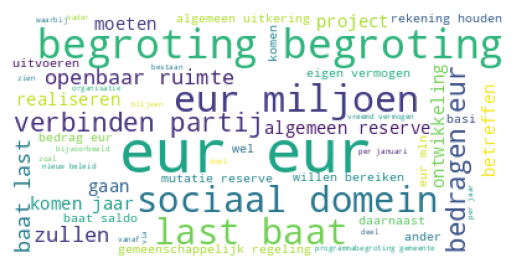

In [33]:
make_word_cloud(GLOB_PB)


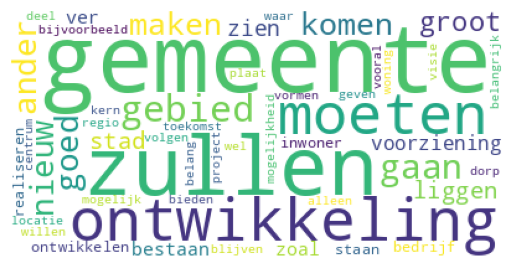

In [34]:
make_word_cloud(GLOB_TV)


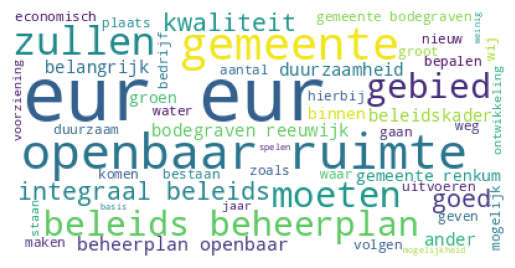

In [35]:
make_word_cloud(GLOB_WS)


---
## Document Type and File Type Counts
Here we count and graph the doucment types and file types, just to add some colour to the document set.

In [36]:
def count_dir(glob):
    mime_types = []
    extensions = []
    docu_types = []

    for from_file in expand_glob(glob):
        mime_type = filetype.guess_mime(from_file)
        if from_file.stem == 'GM1711OB02':
            mime_types.append("text/css")
        elif not mime_type:
            if from_file.suffix.lower() == '.txt':
                mime_types.append("text/plain")
            elif from_file.suffix.lower() == '.zip':
                # seems wrong, but it is correct for our data...
                mime_types.append("text/html")
            else:
                raise Exception(f"don't known how to handle {from_file} of MIME type {mime_type}")
        else:
            mime_types.append(mime_type)
            
        extensions.append(from_file.suffix.lower())
        docu_types.append(from_file.stem[6:8])

    return pd.DataFrame.from_records(list(dict(Counter(mime_types)).items())).set_index(0), \
           pd.DataFrame.from_records(list(dict(Counter(extensions)).items())).set_index(0), \
           pd.DataFrame.from_records(list(dict(Counter(docu_types)).items())).set_index(0)


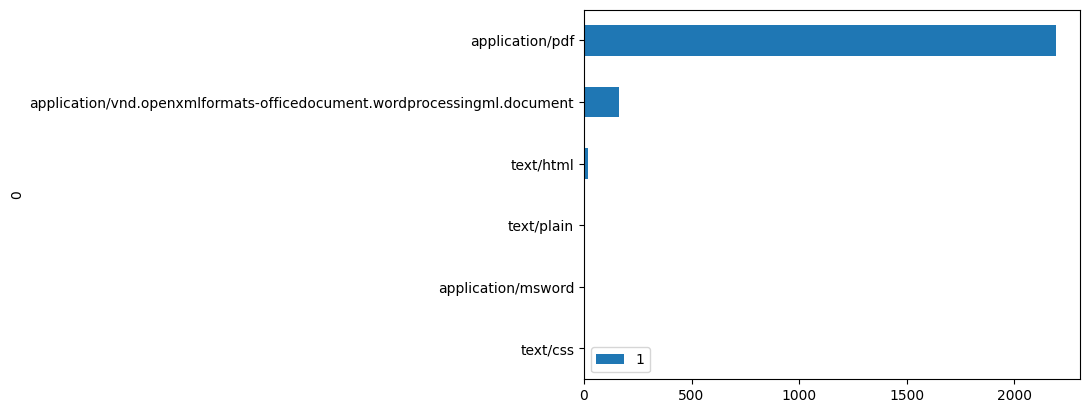

In [37]:
mime_types, extensions, docu_types = count_dir(GLOB_RAW_DOCUMENTS)

mime_types.sort_values(by=1).plot.barh();


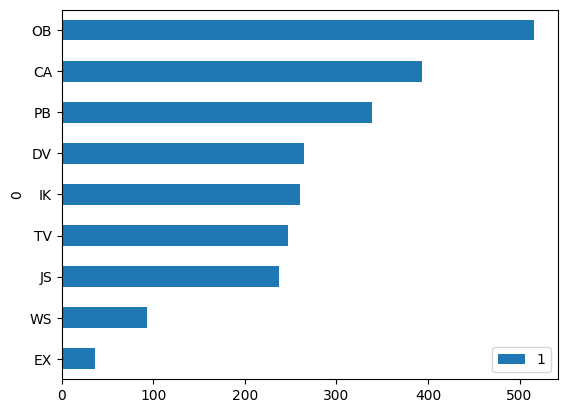

In [38]:
docu_types.sort_values(by=1).plot.barh();

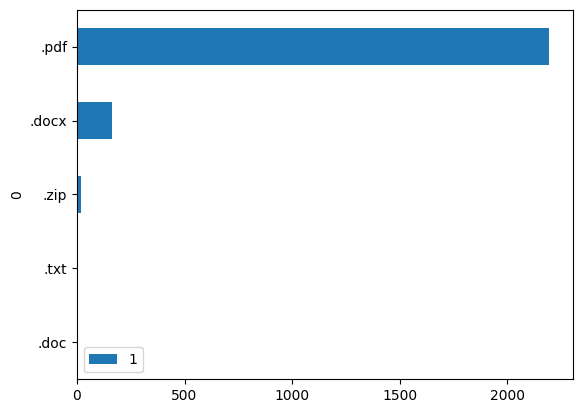

In [39]:
extensions.sort_values(by=1).plot.barh();


---
## Map Documents onto Municipalities
To get some idea of the geographical distribution of the documents that we have available, we map the documents onto a view of the Netherlands.

In [40]:
municipalities_map_with_DV_counts = municipalities_map.join(DV_corpus_with_municipalities[MUNICIPALITY_CODE].value_counts())
municipalities_map_with_DV_counts.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 390 entries, GM0003 to GM1987
Columns: 179 entries, GM_NAAM to count
dtypes: float64(90), geometry(1), int64(86), object(2)
memory usage: 556.5+ KB


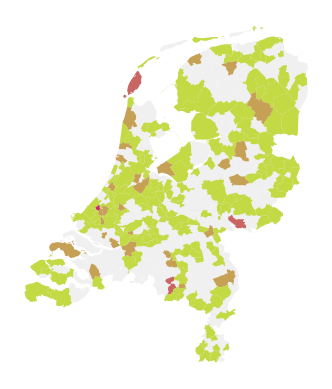

In [41]:
ax = plt.gca()
municipalities_map_with_DV_counts.plot(ax=ax, color=ENEXIS_LIGHTGREY)
municipalities_map_with_DV_counts.plot(ax=ax, column='count', cmap=ENEXIS_CMAP)
ax.axis('off');


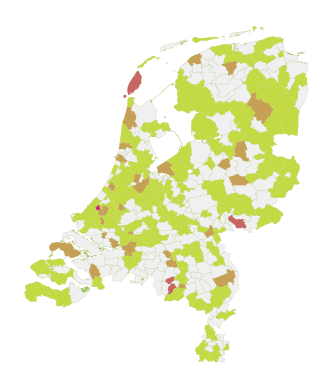

In [42]:
ax = plt.gca()
municipalities_map_with_DV_counts.plot(ax=ax, color=ENEXIS_LIGHTGREY, edgecolor=ENEXIS_DARKGREEN, linewidth=0.1)
municipalities_map_with_DV_counts.plot(ax=ax, column='count', cmap=ENEXIS_CMAP)
ax.axis('off');


### Now Plot All Documents
We repeat the process for all documents, so we can compare the two sets.

In [43]:
ALL_corpus = load_corpus_as_dataframe(GLOB_ALL_DOCUMENTS)
ALL_corpus


,body,GM_CODE
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...,GM0003
GM0003EX06,bedrijventerreinenvisie bedrijventerreinenvisi...,GM0003
GM0003OB01,inkoop aanbestedingsbeleid samenwerken gemeent...,GM0003
GM0003OB02,evaluatie proefproject welzijn nieuw stijl App...,GM0003
GM0005CA01,pvpa christenunie vertrouwen verbinden verantw...,GM0005
...,...,...
GM1987DV01,milieu uitvoeringsprogramma milieu uitvoerings...,GM1987
GM1987IK01,inkoop aanbestedingsbeleid gemeente menterwold...,GM1987
GM1987JS01,rekenkamercommissie rekenkamercommissie gemeen...,GM1987
GM1987PB01,begroting programma begroting begroting inleid...,GM1987


In [44]:
municipalities_map_with_ALL_counts = municipalities_map.join(ALL_corpus[MUNICIPALITY_CODE].value_counts())


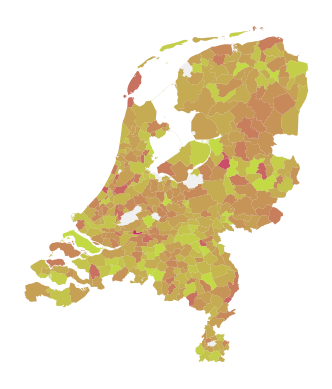

In [45]:
ax = plt.gca()
municipalities_map_with_ALL_counts.plot(ax=ax, color=ENEXIS_LIGHTGREY)
municipalities_map_with_ALL_counts.plot(ax=ax, column='count', cmap=ENEXIS_CMAP)
ax.axis('off');


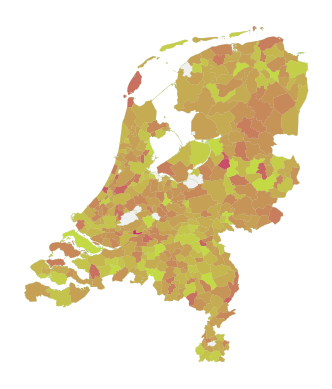

In [46]:
ax = plt.gca()
municipalities_map_with_ALL_counts.plot(ax=ax, color=ENEXIS_LIGHTGREY, edgecolor=ENEXIS_DARKGREEN, linewidth=0.1)
municipalities_map_with_ALL_counts.plot(ax=ax, column='count', cmap=ENEXIS_CMAP)
ax.axis('off');
